# Visualisation et la Recherche d'Images OT Tutoriel

**Tutoriel:** Ce tutoriel couvre les techniques de recherche et d'affichage d'images satellitaires de RADARSAT-1 et MCR avec l'API REST SGDOT.<br>
**Mission et instrument:** Mission de RADARSAT-1 et de la Constellation RADARSAT (MCR)<br>
**Objectif astronomique:** Observation de la Terre<br>
**Données:** Imagerie satellitaire de SGDOT<br>
**Outils primaires:** ipywidgets, ipyleaflet, SGDOT REST API (RAPI)<br>
**Système minimum nécessaire:** Minimum 4 Go de RAM<br>
**Niveau du tutoriel:** Intermédiaire<br> 

### Imports

- [SGDOT RAPI](https://py-eodms-rapi.readthedocs.io/en/latest/search-rapi.html):  Un client REST API pour créer des requêtes de recherche pour SGDOT.
- [ipyleaflet](https://ipyleaflet.readthedocs.io/en/latest/):Une bibliothèque pour créer des cartes interactives dans Jupyter Notebooks, basée sur la populaire bibliothèque JavaScript Leaflet. 
- [ipywidgets](https://ipywidgets.readthedocs.io/en/7.7.0/): Une bibliothèque pour la création de boutons et de widgets interactifs dans Jupyter Notebooks. 
- [Pandas](https://pandas.pydata.org/): Une bibliothèque populaire d'analyse et de manipulation de données.

## Informations générales

RADARSAT-1 a permis au Canada et au monde de bénéficier d'une plateforme avancée de radar à synthèse d'ouverture (SAR) capable d'acquérir des images de la Terre à travers diverses conditions. Ce notamment inclus les conditions de couverture nuageuse, de fumée, de brume, de jour et de nuit. Cette imagerie satellitaire performante s'est avérée précieuse pour de nombreuses applications, notamment la surveillance de l'environnement, l'observation des glaces, l'agriculture, et encore plus! Ces informations se sont également avérées utiles dans la gestion des catastrophes telles que les inondations, les tremblements de terre, les feux de forêt et même les déversements de pétrole.<br>

La mission Constellation RADARSAT (RCM) était la prochaine génération du programme RADARSAT, offrant une qualité, une quantité et une couverture améliorées de 90 % de la surface de la Terre. Ce résultat a été obtenu grâce à trois satellites régulièrement espacés sur la même altitude orbitale de 600 km.<br>

Comme on s'attend à ce que MCR prenne environ 250 000 images par année et que RADARSAT-1 capte plus de 710 000 images accessibles au public au cours de sa durée de vie, un solide système de gestion des données est nécessaire pour distribuer ces données. Ce service est fourni par le Système de gestion des données d'observation de la Terre (SGDOT) géré par Ressources naturelles Canada (RNCan). Ce service offre la possibilité de rechercher et de télécharger une variété de produits d'imagerie. Ce tutoriel vise à utiliser ce service par le biais de l'API REST qui l'accompagne afin de rechercher et d'afficher l'imagerie satellitaire de RARDARSAT-1 et de MCR sur une carte interactive.<br><br>

## Création et initialisation du compte SGDOT

Création et initialisation du compte SGDOT
Pour utiliser le RAPI SGDOT, un compte est nécessaire. Vous pouvez le faire en suivant ce [lien](https://www.eodms-sgdot.nrcan-rncan.gc.ca/index-fr.html) et en sélectionnant "register". Une fois qu'un compte a été créé, veuillez remplacer votre nom d'utilisateur et votre mot de passe dans le fichier d'informations d'identification associé à ce tutoriel.


In [1]:
from eodms_rapi import EODMSRAPI

# external file for credentials
file = open('credentials.txt')
temp = file.read().splitlines()

rapi = EODMSRAPI(temp[0], temp[1])

### Modèle de recherche EODMS

SGDOT propose plusieurs outils différents pour accéder à ses services, notamment une [interface de ligne de commande (CLI)](https://github.com/eodms-sgdot/eodms-cli), une [interface de navigateur web](https://www.eodms-sgdot.nrcan-rncan.gc.ca/index-fr.html) et le [RAPI (compatible avec python)](https://github.com/eodms-sgdot/py-eodms-rapi). À l'aide de cette bibliothèque, nous développerons la structure générale de la création de requêtes de recherche pour SGDOT.

In [2]:
def eodms_search(user, password, collection, features, filters = {}, dates = [], max_results = 1): 
    
    # using a username and password, initializes a connection to EODMS
    rapi = EODMSRAPI(user, password)
    
    # available options for EDOMS search
    rapi.search(collection, filters = filters, features = features, 
                dates = dates, max_results = max_results)
    
    raw_res = rapi.get_results('full')
    results = raw_res
    
    
    return results

### Liste de filtres SGDOT

Comme on peut le voir ci-dessus, plusieurs paramètres peuvent être spécifiés lors de l'exécution d'une recherche avec SGDOT. Il s'agit de critères de recherche comme la date, les caractéristiques géométriques, les filtres de données et la collection. Au cours de ce tutoriel, nous allons couvrir chacun de ces filtres en détail et développer des widgets associés par l'intermédiaire de la bibliothèque ipywidgets pour interagir avec ces filtres. 

#### Collection SGDOT

Tout commence par le paramètre de collection. Ce paramètre spécifie la mission satellite ou les photos aériennes à rechercher. La liste des collections disponibles peut être déterminée à l'aide de la commande suivante.

In [3]:
print(rapi.get_collections(as_list=True))

| EODMSRAPI | 2023-01-26 12:02:08 | Getting Collection information, please wait...
['NAPL', 'SGBAirPhotos', 'RCMImageProducts', 'Radarsat-1_FRED', 'Radarsat1', 'Radarsat1RawProducts', 'Radarsat2RawProducts']


Comme nous l'avons décrit au début du tutoriel, nous utiliserons les produits d'images RADARSAT-1 et RCM. Plus d'informations sur la [Photothèque nationale de l'air (PNA)](https://www.rncan.gc.ca/cartes-outils-et-publications/imagerie-satellitaire-et-photos-aeriennes/photos-aeriennes/phototheque-nationale-lair/9266) et [RADARSAT-2](https://www.asc-csa.gc.ca/fra/satellites/radarsat2/) peuvent être trouvés avec leurs liens respectifs.<br> 

Puisque nous avons une liste d'options disponibles et que nous voulons que les utilisateurs ne sélectionnent qu'une seule option, un bouton radio est un [bon choix](https://designsystem.digital.gov/components/radio-buttons/) pour ce widget particulier. Il peut être créé de la manière suivante.


In [4]:
import ipywidgets as widgets

# creates an instance of a radio button through the ipywidgets library
search_collection = widgets.RadioButtons(
    options=['Radarsat-1', 'RCM Images', 'Radarsat-1 & RCM'],
    description='Collection:',
    disabled=False
)

search_collection

RadioButtons(description='Collection:', options=('Radarsat-1', 'RCM Images', 'Radarsat-1 & RCM'), value='Radar…

Les widgets de la bibliothèque ipywidget possèdent de nombreux attributs et méthodes utiles. Un attribut utile dans notre contexte est la valeur du widget, à laquelle on peut accéder comme suit. 

In [5]:
search_collection.value

'Radarsat-1'

### Filtres de recherche SGDOT

Ensuite, nous allons nous concentrer sur les filtres disponibles pour SGDOT. Ces filtres sont différents pour chaque collection, et spécifient la majorité des options disponibles lors de la recherche avec SGDOT. Ces options comprennent plusieurs filtres importants, notamment des éléments tels que le mode ou la configuration du senseur, le type de polarisation utilisé, la position des satellites, etc.<br>

Nous pouvons générer une liste complète des filtres de recherche disponibles en utilisant la commande suivante. 

In [6]:
print(rapi.get_available_fields('Radarsat1', name_type='title')['search'])

['Orbit Direction', 'Open Data', 'Client Order Number', 'Order Key', 'Product Format', 'Product Id', 'Product Orientation', 'Product Type', 'Sampled Pixel Spacing (Panchromatic)', 'Catalog Visibility Start', 'Collection Id', 'Creation Date', 'Loading Status', 'Owner Id', 'Public Good', 'Subcollection Id', 'Sequence Id', 'Start Date', 'Status', 'End Date', 'UUID', 'Processing Level', 'Look Orientation', 'Beam Id', 'Position', 'Dataset Id', 'Image Id', 'Incidence Angle', 'Absolute Orbit', 'Receive Polarization', 'Sensor Mode', 'Transmit Polarization', 'Incidence Angle (High)', 'Incidence Angle (Low)', 'Spatial Resolution', 'Footprint']


Pour voir les options disponibles pour un filtre particulier, nous pouvons générer les choix de champs disponibles en utilisant la commande suivante.

In [7]:
print(rapi.get_field_choices('Radarsat1', 'Sensor Mode'))

['Fine', 'High Incidence', 'Low Incidence', 'ScanSAR Narrow', 'ScanSAR Wide', 'Standard', 'Wide']


Maintenant que nous connaissons les filtres disponibles et leurs options, nous pouvons commencer à développer un ensemble de widgets pour interagir avec ces filtres. Cependant, comme nous ne voulons pas toujours que certains filtres soient toujours actifs, nous inclurons également un widget de sélection permettant de choisir quand un filtre donné est actif. Ceci peut être réalisé à l'aide de l'option [interactive](https://ipywidgets.readthedocs.io/en/7.7.0/examples/Using%20Interact.html) de la bibliothèque ipywidget. Cela nous permettra d'exécuter une fonction spécifique lorsqu'un widget donné est interagi.

#### Filtres RADARSAT-1 sélectionnés 
Pour Radarsat-1, nous utiliserons les options Sensor Mode (mode capteur) et Transmit Polarization (polarisation de l'émetteur), les valeurs de leurs filtres étant sélectionnées dans la liste créée par la fonction ci-dessus. Nous utiliserons le widget descendante car il peut y avoir plusieurs options disponibles à sélectionner.

In [8]:
from ipywidgets import interactive, GridspecLayout

#---- Beam Mode Widgets

# creates an instance of a checkbox widget
t1 = widgets.Checkbox(
    value=False,
    description='Use Filter',
    disabled=False,
    indent=False
)

# function to disable the dropdown widget containing filter options
def rad_sensor_f(x):
    rad_sensor_opt.disabled = not x

# using the created widget & function, can pass through interactive to have function trigger on action 
rad_sensor_tog = interactive(rad_sensor_f, x = t1);

# dropdown widget with available beam mode options 
rad_sensor_opt = widgets.Dropdown(
    options=['Fine', 'High Incidence', 'Low Incidence', 'ScanSAR Narrow', 'ScanSAR Wide', 'Standard', 'Wide'],
    description='Sensor Mode',
    disabled=True
)

#---- Polarization Widgets (same processes as described above)

t2 = widgets.Checkbox(
    value=False,
    description='Use Filter',
    disabled=False,
    indent=False
)

def rad_polar_f(x):
    rad_polar_opt.disabled = not x
    
rad_polar_tog = interactive(rad_polar_f, x = t2);

rad_polar_opt = widgets.Dropdown(
    options=['H', 'H+V', 'V', 'V+H'],
    description='Transmit Polarization',
    disabled=True
)


#---- Combination of Widgets in a Grid Spacing

radsat_filters = GridspecLayout(2, 2)
radsat_filters[0,0] = rad_sensor_tog
radsat_filters[0,1] = rad_sensor_opt
radsat_filters[1,0] = rad_polar_tog
radsat_filters[1,1] = rad_polar_opt

radsat_filters

GridspecLayout(children=(interactive(children=(Checkbox(value=False, description='Use Filter', indent=False), …

Nous allons répéter le même ordre d'opérations pour les filtres MCR disponibles. Cela commence par l'exploration des filtres MCR disponibles. 

In [9]:
print('Available Filters:')
print(rapi.get_available_fields('RCMImageProducts', name_type='title')['search'])
print('\nBeam Mode Type Filter Options:')
print(rapi.get_field_choices('RCMImageProducts', 'Beam Mode Type'))

Available Filters:
['Orbit Data Source', 'Data Type', 'Sequence Id', 'Special Handling Required', 'Client Order Number', 'Polarization', 'Product Id', 'Product Orientation', 'Sampled Pixel Spacing (Panchromatic)', 'Collection Id', 'Loading Status', 'Open Data', 'Owner Id', 'Public Good', 'Subcollection Id', 'Acquisition Start Date', 'Status', 'Acquisition End Date', 'UUID', 'Processing Level', 'Look Direction', 'Beam Id', 'Beam Mnemonic', 'Dataset Id', 'Downlink segment ID', 'Incidence Angle', 'Absolute Orbit', 'Orbit Direction', 'Relative Orbit', 'Beam Mode Type', 'Order Key', 'Within Orbital Tube', 'Incidence Angle (Low)', 'Spatial Resolution', 'Beam Mode Qualifier', 'Order Purpose', 'Product Format', 'Product Type', 'LUT Applied', 'Creation Date', 'Incidence Angle (High)', 'Processing Date', 'Footprint']

Beam Mode Type Filter Options:
['High Resolution 5m', 'Low Noise', 'Low Resolution 100m', 'Medium Resolution 16m', 'Medium Resolution 30m', 'Medium Resolution 50m', 'Quad-Polarizat

#### Filtres sélectionnés pour MCR 

Un ensemble similaire de filtres sera utilisé pour les requêtes MCR avec l'ajout du filtre Look Up Table (LUT). Ce filtre spécifie le mappage de couleurs pré-appliqué associé à une image satellite donnée. Les différentes LUT peuvent être très utiles lorsqu'on travaille avec des images satellites. Elles permettent de mettre en évidence certaines caractéristiques spectrales d'une image, par exemple en faisant apparaître la glace ou la végétation plus clairement sur une image. 

In [10]:
#---- Beam Mode Widgets

t3 = widgets.Checkbox(
    value=False,
    description='Use Filter',
    disabled=False,
    indent=False
)

def rcm_beam_f(x):
    rcm_beam_opt.disabled = not x
    
rcm_beam_tog = interactive(rcm_beam_f, x = t3);
         
rcm_beam_opt = widgets.Dropdown(
    options=['High Resolution 5m', 'Low Noise', 'Low Resolution 100m', 'Medium Resolution 16m', 'Medium Resolution 30m',\
             'Medium Resolution 50m', 'Quad-Polarization', 'Ship Detection', 'Spotlight', 'Very High Resolution 3m'],
    description='Beam Mode Type',
    disabled = True
)

#---- Polarization Widgets

t4 = widgets.Checkbox(
    value=False,
    description='Use Filter',
    disabled=False,
    indent=False
)

def rcm_polar_f(x):
    rcm_polar_opt.disabled = not x
    
rcm_polar_tog = interactive(rcm_polar_f, x = t4);
         
rcm_polar_opt = widgets.Dropdown(
    options=['CH CV', 'HH', 'HH HV', 'HH HV VH VV', 'HH VV', 'HV', 'VH', 'VH VV', 'VV'],
    description='Polarization',
    disabled = True
)

#---- Look Up Table Widgets 

t5 = widgets.Checkbox(
    value=False,
    description='Use Filter',
    disabled=False,
    indent=False
)

def rcm_lut_f(x):
    rcm_lut_opt.disabled = not x
    
rcm_lut_tog = interactive(rcm_lut_f, x = t5);
         
rcm_lut_opt = widgets.Dropdown(
    options=['Ice', 'Mixed', 'Point Target', 'Ship-1', 'Land', 'Constant-beta', 'Constant-gamma', 'Constant-sigma',\
             'Point Target-1', 'Point Target-2', 'Sea', 'Ship-2', 'Ship-3', 'Unity', 'Unity-beta', 'Unity-gamma', 'Unity-sigma'],
    description='LUT Applied',
    disabled = True
)


#---- Combination of Widgets in a Grid Spacing

rcm_filters = GridspecLayout(3, 2)

rcm_filters[0, 0] = rcm_beam_tog
rcm_filters[0, 1] = rcm_beam_opt
rcm_filters[1, 0] = rcm_polar_tog
rcm_filters[1, 1] = rcm_polar_opt
rcm_filters[2, 0] = rcm_lut_tog
rcm_filters[2, 1] = rcm_lut_opt

rcm_filters

GridspecLayout(children=(interactive(children=(Checkbox(value=False, description='Use Filter', indent=False), …

#### Format de filtre de recherche

Une fois les widgets pour les filtres développés, nous devons transformer les valeurs des widgets au format requis pour une requête SGDOT. Pour cela, les filtres sont spécifiés comme un dictionnaire, chaque filtre étant spécifié comme une clé, et les options d'un filtre étant spécifiées dans un tuple. En outre, à l'aide des boutons à Toggle que nous avons développés, nous pouvons vérifier s'ils sont actifs, en incluant uniquement les filtres qui sont spécifiés.

In [11]:
# function to check which radarsat-1 filters are active, and to add active filters to a dictionary for EODMS search
def rad_filter_togs():
    filters = {}
    
    if rad_sensor_tog.children[0].value:
        filters[rad_sensor_opt.description] = ('like', rad_sensor_opt.value)
        
    if rad_polar_tog.children[0].value:
        filters[rad_polar_opt.description] = ('like', rad_polar_opt.value)
        
    return(filters)

# function to check which rcm filters are active, and to add active filters to a dictionary for EODMS search
def rcm_filter_togs():
    filters = {}
    
    if rcm_beam_tog.children[0].value:
        filters[rcm_beam_opt.description] = ('like', rcm_beam_opt.value)
        
    if rcm_polar_tog.children[0].value:
        filters[rcm_polar_opt.description] = ('like', rcm_polar_opt.value)
        
    if rcm_lut_tog.children[0].value:
        filters[rcm_lut_opt.description] = ('like', rcm_lut_opt.value)
        
    return(filters)

### Glissière de la période de dates

Le prochain paramètre important à inclure dans notre recherche SGDOT est un moyen d'interroger les images dans une période d'acquisition spécifiée. Tout d'abord, nous devons déterminer la période à rechercher dans les données. Pour déterminer la date la plus ancienne possible, on peut utiliser la date du lancement de RADARSAT-1, le 4 novembre 1995. Pour sélectionner la date la plus récente, nous pouvons utiliser la date d'aujourd'hui, car la mission de la Constellation RADARSAT (MCR) capture encore des images à ce jour! (au moment de la publication de ce tutoriel)<br>

En utilisant les dates de début et de fin, nous pouvons utiliser une fonction utile de pandas pour créer un index de période de dates avec une fréquence d'un mois. Cet index peut ensuite être formaté à l'aide de la fonction strftime pour être affiché et mis en forme dans le style requis pour la requête de recherche SGDOT.<br>

Enfin, en utilisant les options formatées ci-dessus, nous sommes en mesure de créer un glisseur de plage de sélection à partir de la bibliothèque ipywidgets.


In [12]:
import pandas as pd
from datetime import datetime

# initial and end date of the slider
start_date = datetime(1995, 11, 4)
end_date = datetime.today()

# creates a dataframe between starting and ending dates equally iterated by month
dates_pd = pd.date_range(start_date, end_date, freq='M')

# iterates through dataframe formatting dates to a month year format for displaying, and required format for EODMS search
options = [(date.strftime('%b %Y'), date.strftime('%Y%m%d_%H%M%S')) for date in dates_pd]
index = (0, len(options)-1)

# creation of date slider
selection_range_slider = widgets.SelectionRangeSlider(
    options=options,
    index=index,
    description='Date Range:',
    orientation='horizontal',
    layout={'width': '500px'}
)

display(selection_range_slider)

# function to select for currently active starting and ending date of slider
def format_date_range():
    dates = [{"start": selection_range_slider.value[0], "end": selection_range_slider.value[1]}]

SelectionRangeSlider(description='Date Range:', index=(0, 325), layout=Layout(width='500px'), options=(('Nov 1…

### Formatage et analyse des métadonnées

Maintenant que nous disposons des filtres de recherche requis, nous pouvons nous intéresser aux résultats de notre requête de recherche. L'interface RAPI du SGDOT permet de renvoyer soit un ensemble limité de résultats (raw) ou soit l'ensemble complet des résultats disponibles (full). Si vous choisissez l'ensemble limité de résultats, vous pouvez spécifier des champs supplémentaires à inclure en ajoutant un filtre de recherche de résultats. Dans le cadre de ce tutoriel, nous utiliserons l'ensemble complet de résultats.<br> 

L'ensemble des résultats disponibles peut être consulté ci-dessous. 


In [13]:
print(rapi.get_available_fields('Radarsat1', name_type='title')['results'])

['Buyer Id', 'Archive Visibility Start Date', 'Client Order Item Number', 'Client Order Number', 'Client Project Name', 'Delivery Date', 'EULA Filename', 'Geographical Area', 'Notified Client Email List', 'Order Key', 'Processing Date', 'Processor Name', 'Processor Version', 'Product Datum', 'Product Ellipsoid', 'Product Id', 'Product Map Projection', 'Product Map Zone', 'Product Orientation', 'Product Type', 'Provider Id', 'Quicklook Full Name', 'SIP Size (MB)', 'Supplier Order Item Number', 'Supplier Order Number', 'Geodetic Terrain Height', 'Sampled Pixel Spacing (Panchromatic)', 'Reason', 'Collection Id', 'Title', 'Metadata Full Name', 'Owner Id', 'Public Good', 'Subcollection Id', 'Sensor Folder', 'Sensor Id', 'Sequence Id', 'Service UUID', 'Start Date', 'End Date', 'Footprint', 'EULA Url', 'Feature ID', 'Sensor', 'Metadata', 'Options', 'Orderable', 'Metadata Full URL', 'Processing Level', 'Product Format', 'Related Products', 'Look Orientation', 'Band', 'Position', 'Dataset Id', 

#### Formatage des métadonnées

À partir de l'ensemble des résultats, nous utiliserons une sous-section de champs pour afficher des informations utiles associées à l'imagerie. Ces informations seront formatées avec du HTML simple qui sera utilisé dans une fenêtre contextuelle affichée sur la carte ipyleaflet. 

In [14]:
from ipywidgets import HTML

# formats available metadata for either radarsat-1 or rcm 
def format_meta_display(collection, results):
    
    info = HTML()
       
    if collection == 'Radarsat1':
        info.value = ('<b>Image Title: </b>' + results['title'] + \
        '<br /><b>Acquisition: </b>' + results['startDate'] + \
        '<br /><b>Beam Description: </b>' + results['beam'] + \
        '<br /><b>Band Description: </b>' + results['band'] + \
        '<br /><b>Polarization: </b>' + results['polarization'] + \
        '<br /><b>LUT: </b>' + results['lutApplied'])
        
        url = results['overviewUrl']
    
    elif collection == 'RCMImageProducts':
        info.value = ('<b>Image Project: </b>' + results['clientProjectName'] + \
        '<br /><b>Acquisition: </b>' + results['acquisitionStartDate'] + \
        '<br /><b>Beam Description: </b>' + results['beamModeDescription'] + \
        '<br /><b>Polarization: </b>' + results['polarization'] + \
        '<br /><b>LUT: </b>' + results['lutApplied'])
        
        url = results['thumbnailUrl']
    
    return info, url

    

#### Analyse des métadonnées

À partir des résultats, nous sélectionnerons aussi des informations sur la géométrie de l'image. Ces informations seront utilisées pour déterminer les coordonnées nord-est (en haut à droite) et sud-ouest (en bas à gauche) de l'image. Ces coordonnées seront ensuite utilisées dans les limites d'affichage de l'image satellite superposée à la carte. 

In [15]:
def image_bounds(results):
    
    bounds = []
    
    for i in results: 
        coordinates = i['geometry']['coordinates'][0]
        
        # initial temp coordinates
        max_x = coordinates[0][0]
        min_x = coordinates[0][0]
        max_y = coordinates[0][1]
        min_y = coordinates[0][1]
        
        # iterates rather than min/max as coordinates are stored as a list of lists 
        # (alternative strategy would be creating a list of x and y coordinates, and select min/max from there)
        for j in coordinates:
            if max_x < j[0]:
                max_x = j[0]
                
            if max_y < j[1]: 
                max_y = j[1]
                
            if min_x > j[0]:
                min_x = j[0]
                
            if min_y > j[1]: 
                min_y = j[1]
        
        NE = (max_y, max_x)
        SW = (min_y, min_x)
        # format required for EODMS search
        temp_bounds = {'NE': NE, 'SW': SW}
        bounds.append(temp_bounds)
        
    return bounds
        

### Opacité de l'image

L'un des derniers widgets que nous allons développer est une option permettant de modifier l'opacité des images affichées. Ce widget sera similaire à celui de notre filtre de dates de données, car nous développons un glisseur, mais cette fois-ci, nous utiliserons le widget float slider d'ipywidgets. Pour cela, nous devons définir les valeurs min, max et le niveau de notre valeur. Nous utiliserons une plage de 0 à 1, 0 représentant la transparence totale et 1 l'opacité totale. Ensuite, nous allons également créer un simple widget de liste descendante pour sélectionner l'image superposée que nous souhaitons modifier.<br> 

Une fois ces widgets développés, nous les ferons passer par la fonction interactive avec l'option de sélection manuelle activée pour que les images sélectionnées soient mises à jour au moment voulu.  


In [16]:
from ipywidgets import FloatSlider

# function to update image opacity with value x if images are available of value y
def update_opacity(x, y):
    if y == 'No Image': 
        display('No Images Available to Update')
    else:
        m.layers[y].opacity = x

# float widget with slider between 0-1 
opacity_slider = widgets.FloatSlider(
    description='Opacity:', 
    min=0, 
    max=1, 
    step=0.01, 
    value=1
)     

# widget to select which image to update
image_list = widgets.Dropdown(
    options=['No Image'],
    description='Image:',
    disabled=False,
)

# interactive widget to only trigger when the update image button is clicked
image_opacity = interactive(update_opacity, {'manual': True}, x=opacity_slider, y=image_list)
image_opacity.children[2].description = 'Update Image'

image_opacity

interactive(children=(FloatSlider(value=1.0, description='Opacity:', max=1.0, step=0.01), Dropdown(description…

#### Mise à jour de la liste des images 

Comme vous l'avez peut-être remarqué ci-dessus, notre liste d'images ne contient aucune image ! Par conséquent, nous allons développer une certaine logique pour rechercher des images chaque fois que la carte est mise à jour avec une nouvelle superposition d'images satellites. 

In [17]:
from ipyleaflet import ImageOverlay

# function to update available images for opacity update
def update_image_list(): 
    image_names = []
    image_idx = []

    # getting image overlay class from ipyleaflet
    image_class = type(ImageOverlay())

    # enumerates for all available map layers in ipyleaflet map
    for idx, i in enumerate(m.layers):
        # if a layer is of the imageoverlay class, appends the index and name of that particular layer to a list
        if isinstance(i, image_class):
            image_names.append(i.name)
            image_idx.append(idx)

    image_options = []

    # combines image names and image indexes in a tuple 
    for i, j in zip(image_names, image_idx):
        image_options.append((i, j))

    # if no images on map, sets image options to no image
    if len(image_options) == 0: 
        image_options=['No Image']

    # updates the image list widget with the update names
    image_opacity.children[1].options = image_options

## Visualisation et création de la carte 

La dernière étape de ce tutoriel consistera à combiner tous les widgets ci-dessus et les critères de recherche en une carte interactive et recherchable ! Nous utiliserons la bibliothèque ipyleaflet comme affichage principal pour cette section. Ce package permet de créer et d'afficher rapidement des cartes, comme illustré ci-dessous.

In [18]:
from ipyleaflet import basemaps, Map, SearchControl, ZoomControl, DrawControl,\
FullScreenControl, Marker, AwesomeIcon, LayersControl

center = [45.520261, -73.393618]
m = Map(basemap=basemaps.Esri.WorldStreetMap, center=center, zoom=3, zoom_control=False)
display(m)

Map(center=[45.520261, -73.393618], controls=(AttributionControl(options=['position', 'prefix'], position='bot…

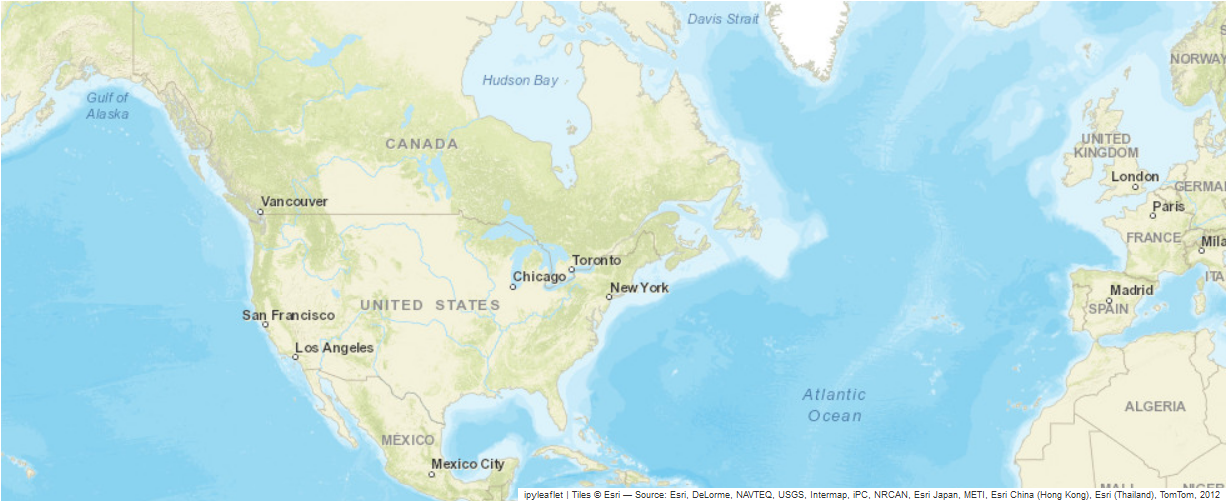

### Logique de recherche d'images

Afin de développer une expérience interactive robuste, nous devons mettre au point un ensemble de logiques permettant d'attraper une variété de conditions et de paramètres de recherche différents. Cela peut sembler compliqué à première vue, cependant, une grande partie de la définition de la fonction consiste à exécuter la même fonction de recherche SGDOT que nous avions développée au début du tutoriel. 

In [19]:
# search logic function 
from ipyleaflet import Popup
from IPython.display import clear_output

# function with inputs of if the search or draw was used, and relavent search parameters for EODMS
def image_map_search(search_bool, draw_bool, collections, filters = {}, dates = [], max_num = 1):
    
    file = open('credentials.txt')
    temp = file.read().splitlines()
    
    # clearing previous image and geometry layers (popups, pins, etc) on map
    for i in range(len(m.layers[2:])): 
        m.remove_layer(m.layers[-1])
    
    # checking if both radarsat-1 & rcm were active in collections radio widget, and performing search required amount of times
    if len(collections) == 1:
        search_conditions(search_bool, draw_bool, collections[0], filters, dates = dates, max_num = 1)
        
    elif len(collections) == 2: 
        search_conditions(search_bool, draw_bool, collections[0], filters[0], dates = dates, max_num = 1)
        search_conditions(search_bool, draw_bool, collections[1], filters[1], dates = dates, max_num = 1)

    # clearing drawn polygons
    draw_control.clear()
    # clearing drawn geometry
    feature_collection['features'].clear()

        
def search_conditions(search_bool, draw_bool, collection, filters = {}, dates = [], max_num = 1):    
    # search process if location search was used
    if search_bool[0] and not draw_bool[0]: 
        # formatting geometry for EODMS search
        search_geo = [('intersects', {'type': 'Point', 'coordinates': [search_location[0][1], search_location[0][0]]})]
        print('Image Search Using Searched Location')

        # executing EODMS search
        results = eodms_search(temp[0], temp[1], collection, search_geo, filters = filters, dates = dates, max_results = max_num)
        bounds = image_bounds(results)
        
        if len(results) == 0:
            print('\nNo Satellite Images Were Found')
            return -1

        # for the amount of results returned
        for j in range(len(results)):
            
            # formatting metadata for image display
            info, url = format_meta_display(collection, results[j])
            
            # creation of new image layer of satellite imagery
            image = ImageOverlay(
                url = url,
                bounds = (bounds[j]['SW'], bounds[j]['NE']),
                name = collection + ' ' + str(j + 1)
            )

            m.add_layer(image)
            
            # marker to display popup metadata about the displayed imagery
            marker = Marker(location = bounds[j]['NE'], icon=AwesomeIcon(name="info", marker_color='darkblue', icon_color='white'),\
                  draggable=False, name=(collection + ' Info ' + str(j + 1)))
            m.add_layer(marker)
            # formatted metadata for the popup when clicked
            marker.popup = info

        return 0

    # search process if drawn geometry was used
    elif draw_bool[0] and not search_bool[0]: 
        draw_geo = []
        # selecting geometry from drawn features
        for i in range(len(feature_collection['features'])):
            temp_geo = [('intersects', feature_collection['features'][i]['geometry'])]
            draw_geo.append(temp_geo)
        print('Image Search Using Drawn Location')

        for i in range(len(draw_geo)):
            # executing EODMS search
            results = eodms_search(temp[0], temp[1], collection, draw_geo[i], filters = filters, dates = dates, max_results = max_num)
            bounds = image_bounds(results) 

            try: results
            # catch if the same geometry was used but cleared 
            except NameError: 
                print('\nPlease Use New Geometry or Retry Geometry')
                return -1

            if len(results) == 0:
                print('\nNo Satellite Images Were Found')
                return -1

            for j in range(len(results)):
                info, url = format_meta_display(collection, results[j])
                
                image = ImageOverlay(
                    url = url,
                    bounds = (bounds[j]['SW'], bounds[j]['NE']),
                    name = collection + ' ' + str(i) + '-' + str(j)
                )

                m.add_layer(image)
                
                marker = Marker(location = bounds[j]['NE'], icon=AwesomeIcon(name="info", marker_color='darkblue', icon_color='white'),\
                      draggable=False, name=(collection + ' Info ' + str(i) + '-' + str(j)))
                m.add_layer(marker)
                                
                marker.popup = info
                
        return 0 

    # catch for other errors or conditions 
    else:
        print('Searchable Geometry was not Provided or an Error Occured')
        return -1


### Bouton de recherche  

Une fois les critères de recherche élaborés, nous allons créer notre widget final, à savoir un bouton de recherche pour exécuter les critères de recherche ci-dessus. 

In [20]:
# function to execute the search criteria when the search button is clicked
def execute_search(obj):
    # clears console prints
    clear_output()
    # redisplays the map and widgets
    display(m)  
    display(tab_nest)

    # formats the daterange slider for use in EODMS search
    date_range = format_date_range()
    
    # conditions for which collection is selected, calls function to create filter dictionary, and calls the search criteria
    if search_collection.value == 'Radarsat-1':
        rad_filter_dict = rad_filter_togs()
        image_map_search(search_bool, draw_bool, ['Radarsat1'], filters = rad_filter_dict, dates = date_range, max_num = 1)

    elif search_collection.value == 'RCM Images':
        rcm_filter_dict = rcm_filter_togs()
        image_map_search(search_bool, draw_bool, ['RCMImageProducts'], filters = rcm_filter_dict, dates = date_range, max_num = 1)

    elif search_collection.value == 'Radarsat-1 & RCM':
        rad_filter_dict = rad_filter_togs()
        rcm_filter_dict = rcm_filter_togs()
        image_map_search(search_bool, draw_bool, ['Radarsat1', 'RCMImageProducts'], filters = [rad_filter_dict, rcm_filter_dict],\
                         dates = date_range, max_num = 1)

    # updates image list for image opacity slider 
    update_image_list() 
    print('Image Search Complete')

# creation of search button widget
search_button = widgets.Button(description = "Search")
    
# executes the above function when the button is clicked
search_button.on_click(execute_search)

### Combinaison de widgets

Les widgets associés à la recherche développée seront placés dans un modèle de mise en page de l'application. Il s'agit d'un modèle similaire à la grille utilisée précédemment, avec un style différent en termes de taille. 

In [21]:
from ipywidgets import AppLayout, Layout

search_layout = AppLayout(header=None,
          left_sidebar=search_button,
          center=search_collection,
          right_sidebar=image_opacity,
          footer=selection_range_slider,
          pane_widths=[1, 2, 2])

#### Mise en page de l'onglet

Une fois tous les boutons développés, nous allons les combiner dans une disposition en onglet. Cela nous permettra de changer entre les différentes options de filtre disponibles.

In [22]:
tab_nest = widgets.Tab()
tab_nest.children = [search_layout, radsat_filters, rcm_filters]
tab_nest.set_title(0, 'Search Tab')
tab_nest.set_title(1, 'Radarsat-1 Filters')
tab_nest.set_title(2, 'RCM Image Filters')

### Création de la carte

Finalement, nous allons construire la carte que nous utiliserons pour afficher l'imagerie satellite. Un élément important de cette carte sera l'extraction d'informations géospatiales à utiliser dans les critères de recherche du SGDOT. Nous chercherons à développer deux options pour générer des critères de recherche géospatiaux, soit par l'utilisation d'une barre de recherche, soit par le dessin de marqueurs et de polygones sur la carte elle-même. 

In [23]:
from ipyleaflet import basemaps, Map, SearchControl, ZoomControl, DrawControl,\
FullScreenControl, Marker, AwesomeIcon, LayersControl

# creation of map with specified center and basemap, zoom controsl set to false to reposition it later on
center = [45.520261, -73.393618]
m = Map(basemap=basemaps.Esri.WorldStreetMap, center=center, zoom=3, zoom_control=False)

# adding fullscreen and zoom controls to map
m.add_control(FullScreenControl(position='topright'))
m.add_control(ZoomControl(position='topleft'))

# setting a marker for the Canadian Space Agency Headquarters in Saint-Hubert
headquarters = Marker(location = center, icon=AwesomeIcon(name="space-shuttle", marker_color='darkblue', icon_color='white'), draggable=False,\
                     name='Headquarters')

m.add_layer(headquarters);

# marker style to display when a searched location is found
marker = Marker(icon=AwesomeIcon(name="globe", marker_color='green', icon_color='darkgreen'), draggable=False)

search = SearchControl(
    position = "topleft",
    url = 'https://nominatim.openstreetmap.org/search?format=json&q={s}?',
    zoom = 10,
    marker = marker
)

m.add_control(search)

# list for if location search or drawn geometry is used
search_bool = [{}]
draw_bool = [{}]

search_location = [{}]

# function to execute when the location search with input of variable unpackable dictionary item from the loaction search
def on_found(**kwargs):
    # coodinates of searched location
    search_location[0] = kwargs['location']
    # logic to set that location search was used
    search_bool[0] = True
    draw_bool[0] = False
    # clears previously drawn features
    draw_control.clear()
    feature_collection['features'].clear()
    marker.visible = True

search.on_location_found(on_found)



draw_control = DrawControl(
position = 'bottomleft'
)

# drawn features dictionary in geojson foramt
feature_collection = {
    'type': 'FeatureCollection',
    'features': []
}


def handle_draw(self, action, geo_json):
    # updates the drawn geometry list
    feature_collection['features'].append(geo_json)
    # updates the search logic
    search_bool[0] = False
    draw_bool[0] = True
    marker.visible = False

# executes function following drawing
draw_control.on_draw(handle_draw)

m.add_control(draw_control)

# adds controls to choose which layers to display
layers_control = LayersControl(position='bottomright')
m.add_control(layers_control)

La dernière étape consiste maintenant à afficher la carte et les widgets disponibles que nous avons créés ! Vous avez maintenant la possibilité d'explorer et de rechercher les images satellites disponibles. 

In [24]:
display(m)  
display(tab_nest)

Map(center=[45.520261, -73.393618], controls=(AttributionControl(options=['position', 'prefix'], position='bot…

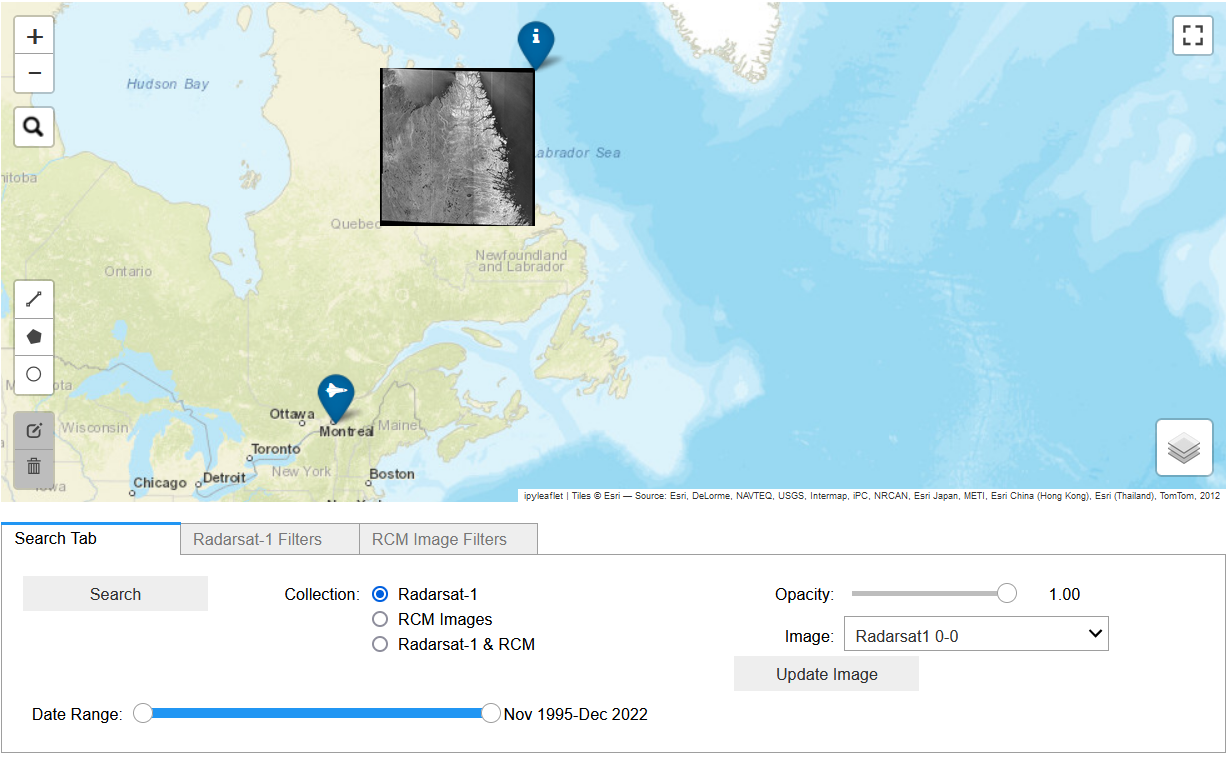